# Reading data

In [208]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

#Modelling
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [234]:
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
opinion_df = df[['movie_identifier','actor_identifier','identifier','actor_gender','category', 'winner', 'oscar_nominated', 'average_rating', 'number_of_votes']]

# Correlation

In [20]:
#Since the ratings are movie based, refactor data like so for general corellation measuring:
#Take one line for each movie. If that movie was nominated at least once, oscar_nominated = 1, else 0
nominated_movies = opinion_df[opinion_df['oscar_nominated'] == True]
#Add nominated movies to the top to ensure that the movies kept are first
each_movie_once_df = pd.concat([nominated_movies, opinion_df], axis=0)

each_movie_once_df = each_movie_once_df.drop_duplicates(subset='movie_identifier', keep='first')

[]

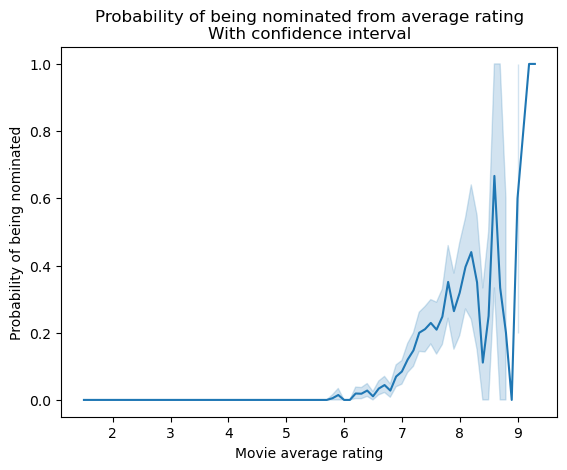

In [41]:
sns.lineplot(data=each_movie_once_df, x="average_rating", y="oscar_nominated")
plt.ylabel("Probability of being nominated")
plt.xlabel("Movie average rating")
plt.title("Probability of being nominated from average rating\nWith confidence interval")
plt.plot()

It is pretty well seen, that in general, with the average rating rising the chances to be nominated do as well. As the upper area of average ratings is rarer, the model becomes more unpredictable.

It is also noteworthy that the confindence interval when the probability of nomination is bigger is very large, meaning that the true mean of the probability could be 0 or 1. Overall though, the probability is quite clearly trending upwards with the average rating

In [31]:
binned_data

,binned_nr_votes,oscar_nominated
0,"(-2929.752, 296005.2]",0.056892
1,"(296005.2, 591980.4]",0.153571
2,"(591980.4, 887955.6]",0.154930
3,"(887955.6, 1183930.8]",0.312500
4,"(1183930.8, 1479906.0]",0.333333
5,"(1479906.0, 1775881.2]",0.500000
6,"(1775881.2, 2071856.4]",0.200000
7,"(2071856.4, 2367831.6]",0.500000
8,"(2367831.6, 2663806.8]",0.000000
9,"(2663806.8, 2959782.0]",1.000000


[]

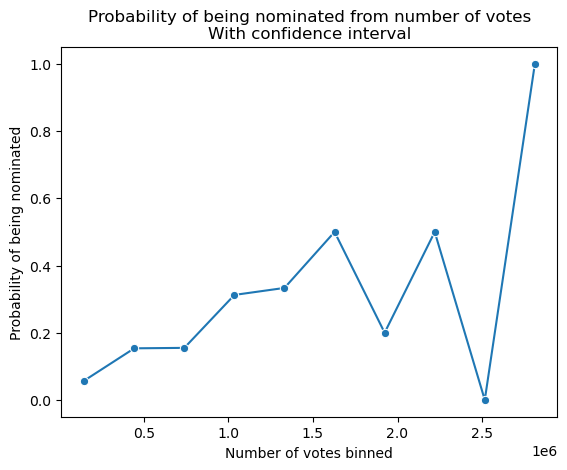

In [40]:
each_movie_once_df['binned_nr_votes'] = pd.cut(each_movie_once_df['number_of_votes'], bins=10)
binned_data = each_movie_once_df.groupby('binned_nr_votes', observed=False)['oscar_nominated'].mean().reset_index()
binned_data['binned_nr_votes'] = binned_data['binned_nr_votes'].apply(lambda x: x.mid)

sns.lineplot(data=binned_data, x='binned_nr_votes', y="oscar_nominated", marker="o")
plt.ylabel("Probability of being nominated")
plt.xlabel("Number of votes binned")
plt.title("Probability of being nominated from number of votes\nWith confidence interval")
plt.plot()

Notebly the number of votes a movie got also seems to be positively correlated with its odds of being nominated. This is likely due to the movies nominated having a lot of publicity and hence receiving more votes

# logistic regression

For seeing if a movie being nominated for an oscar is predictable from the ratings it got and the number of them, we need to use the aforementioned transformation again: each movie only has one row, and if at least one actor was nominated then the whole movie is nominated.

In [75]:
#Conducts logistic regression on the given split
def log_regression(X_train, X_test, y_train, y_test):
    # Normalize the data, fitting the scaler only to train and transforming both train and test
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Add constants
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    model = sm.Logit(y_train, X_train)
    return model.fit()

In [102]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

result = log_regression(X_train, X_test, y_train, y_test)

Optimization terminated successfully.
         Current function value: 0.176840
         Iterations 9


In [140]:
def find_optimal_cutoff(y_test, output, cutoffs):
    best_f1 = 0
    best_threshold = 0

    for cutoff in cutoffs:
        predictions = output > cutoff
        temp_f1 = sklearn.metrics.f1_score(y_test, predictions)
        if temp_f1 > best_f1:
            best_f1 = temp_f1
            best_threshold = cutoff
    print('Best threshold:', best_threshold)
    print('Best F1:', best_f1)

    predictions = output > best_threshold
    
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print('Accuracy:', accuracy)
    precision = sklearn.metrics.precision_score(y_test, predictions)
    print('Precision:', precision)
    recall = sklearn.metrics.recall_score(y_test, predictions)
    print('Recall:', recall)

In [103]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0
Best F1: 0
Accuracy: 0.7863105175292153
Precision: 0.006024096385542169
Recall: 0.010869565217391304


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


The data is way too imbalanced to work. With every possible cutoff at most 1 test instance gets classified to be nominated. Attempting with data rebalancing

## With rebalanced data

### Oversampling

In [137]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Oversample
#At maximum triple the amount of positive samples
sampling_strategy = {False: y_train.value_counts().iloc()[0], 1: y_train.value_counts().iloc()[1] * 5}

ros = RandomOverSampler(random_state=42, sampling_strategy = sampling_strategy)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

result = log_regression(X_resampled, X_test, y_resampled, y_test)

Optimization terminated successfully.
         Current function value: 0.375214
         Iterations 7


In [141]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0
Best F1: 0
Accuracy: 0.82220367278798
Precision: 0.008130081300813009
Recall: 0.010869565217391304


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Oversampling did not solve the problem, the model still predicts "not nominated" for almost all movies

### Undersampling

In [175]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Oversample
#Reduce the number of negative samples by 3fold
sampling_strategy = {False: y_train.value_counts().iloc()[0] // 3, 1: y_train.value_counts().iloc()[1]}
rus = RandomUnderSampler(random_state=42, sampling_strategy = sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
result = log_regression(X_resampled, X_test, y_resampled, y_test)

Optimization terminated successfully.
         Current function value: 0.312782
         Iterations 8


In [176]:
y_resampled.value_counts()

oscar_nominated
False              1496
True                302
Name: count, dtype: int64

In [177]:
#Evaluate
output = result.predict(sm.add_constant(X_test))

#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output, np.linspace(0.1,1,10))

Best threshold: 0
Best F1: 0
Accuracy: 0.8171953255425709
Precision: 0.007751937984496124
Recall: 0.010869565217391304


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Undersampling has no effect either, could be that oscar nominations are simply not linearly modellable from popular opinion.

# DecisionTree

In [194]:
def evaluate_predictions(y_test, output):
    print('Accuracy:', sklearn.metrics.accuracy_score(y_test, output))
    print('Precision:', sklearn.metrics.precision_score(y_test, output))
    print('Recall:', sklearn.metrics.recall_score(y_test, output))
    print('F1:', sklearn.metrics.f1_score(y_test, output))

In [226]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(random_state=42)

In [227]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.9015025041736227
Precision: 0.32432432432432434
Recall: 0.2608695652173913
F1: 0.2891566265060241


In [228]:
print(f"Trained model depth is {model.get_depth()} ; Number of leaves {model.get_n_leaves()}")

Trained model depth is 43 ; Number of leaves 503


Decision tree is able to solve this problem somewhat, although not with the perhaps desired accuracy. Additionally, the model trained has a huge complexity, even though it only posessed 2 features. This could indicate the model hardcoding a path for all instances and not finding any true patterns

In [193]:
#tree.plot_tree(model)

## Limiting tree depth

In [224]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = tree.DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=5, random_state=42)

In [225]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.9232053422370617
Precision: 0.0
Recall: 0.0
F1: 0.0


C:\Users\rasmu\anaconda3\envs\ADA\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Indeed with a limited space the tree is not able to model being nominated for a oscar, indicating that this is a complex problem

# Randomforest

In [229]:
X = each_movie_once_df[['average_rating', 'number_of_votes']]
y = each_movie_once_df[['oscar_nominated']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [230]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Accuracy: 0.9098497495826378
Precision: 0.375
Recall: 0.2608695652173913
F1: 0.3076923076923077


As expected, randomforest is able to squeeze the most information out of the data given. In total predicting with a 91% accuracy what movies will be nominated is not at all a bad score. However the recall and precision are not great, with only 1 in every 4 movies that are nominated caught by this model

# Predicting specific award categories
As seen before then linear models perform terribly for predicting from scores, so I will only use non-linear models such as the random forest

In [235]:
# As the categories are gendered I will need to extract different datasets for men and women
men_df = opinion_df[opinion_df['actor_gender'] == 'M']
women_df = opinion_df[opinion_df['actor_gender'] == 'F']

In [237]:
opinion_df['category'].value_counts()

category
ACTOR IN A LEADING ROLE         114
ACTOR IN A SUPPORTING ROLE      111
ACTRESS IN A SUPPORTING ROLE    104
ACTRESS IN A LEADING ROLE        90
ACTOR                            57
ACTRESS                          43
Name: count, dtype: int64

## Best actor

In [236]:
men_df

,movie_identifier,actor_identifier,identifier,actor_gender,category,winner,oscar_nominated,average_rating,number_of_votes
0,ghosts of mars_2001,/m/01vw26l,ghosts of mars_2001_ice cube,M,NaN,NaN,False,4.9,58872
51,alexanders ragtime band_1938,/m/02s58t,alexanders ragtime band_1938_tyrone power,M,NaN,NaN,False,6.8,2357
74,henry v_1989,/m/016gr2,henry v_1989_derek jacobi,M,NaN,NaN,False,7.5,32088
75,henry v_1989,/m/016zp5,henry v_1989_ian holm,M,NaN,NaN,False,7.5,32088
77,henry v_1989,/m/01wy5m,henry v_1989_christian bale,M,NaN,NaN,False,7.5,32088
...,...,...,...,...,...,...,...,...,...
443404,state and main_2000,/m/023kzp,state and main_2000_william h macy,M,NaN,NaN,False,6.7,22784
443407,state and main_2000,/m/02qgqt,state and main_2000_philip seymour hoffman,M,NaN,NaN,False,6.7,22784
443408,state and main_2000,/m/02t_vx,state and main_2000_david paymer,M,NaN,NaN,False,6.7,22784
443414,state and main_2000,/m/060j8b,state and main_2000_john krasinski,M,NaN,NaN,False,6.7,22784
